# Tutorial: obtaining the Koopman generator via Newton's extrapolation

This tutorial shows you how to compute the infinitesimal generator with the Newton's polynomial extrapolation.<br\>
First, load the modules we need. In addition to numpy and matplolib, we use the picking algorithm, Galerkin discretization for different lagtimes, Newton extrapolation, pcca+.

In [1]:
#standard libraries
import numpy as np
import matplotlib.pyplot as plt
#from cmdtools
from cmdtools.analysis import pcca
from cmdtools.estimation import galerkin_taus_all, Newton_Npoints, picking_algorithm, centers_select_criteria

Load the trajectory data from  the directory and the centers for the Gaussian membership fuctions computed with the picking algorithm.<br\> We load the coordinates of the centers to make this tutorial faster. In case you want to vary the number of centers or to try by yourself how this algorthm works, uncomment the line below and comment the line that loads the centers coordinates. The picking algorithm requires a bit of time and we suggest you save the coordinates of your centers. 

In [16]:
#load trajectory 
diala = np.load("arr_0.npy")
#pick the centers for the basis functions
centers = picking_algorithm.picking_algorithm(diala[::25,:], 350)[0]
# we reccomend to sort your centers so that you can visualize them later.
centers= centers[centers[:, 0].argsort()]

We visualize the position of the picked points in the state space.<br\>
You can see that this algorithm ensures that the sampling is localized in the region of of the state space covered by the trajectory. 

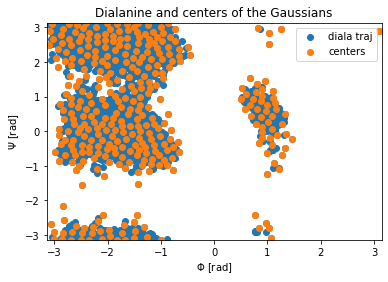

In [20]:
plt.scatter( diala[::25, 0], diala[::25, 1], label= "diala traj")
plt.scatter(centers[:, 0], centers[:, 1], label= "centers")
plt.xlabel("$\Phi$ [rad]")
plt.ylabel("$\Psi$ [rad]")
plt.title("Dialanine and centers of the Gaussians")
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.legend()
plt.show()

Now we have everything to compute the Koopman matrices via Galerkin discretization. We compute a set of transfer matrices for different multiples of a timestep $\tau$. So first we set $\tau$=5, but you can try to vary it as see how the results change.

We compute then the transfer matrix for $0,1,2,3,4$ times $\tau$. We save it in a numpy array, whose first index $n$ indicates the $n\cdot \tau$ lagtime used to compute the Koopman matrix $K(n\cdot \tau)$.

We set the parameter $\sigma$ for the variance of the Gaussian to $\sigma=0.09$. 

In [18]:
Koopman_mtx, m = galerkin_taus_all.propagator_tau(diala[::5,:], centers, 0.09, 4)

With small numbers can be tricky, above all when normalizing.

That causes that in the first matrix $K(\tau=0)$, the diagonal entry has not the biggest value. 

This would mean that the observable "without moving" would most likely end up in a new region. This does not make sense and is just a numerical artefact.
Our solution is to remove all the centers associated with this problem. 

To facilitate the readibility, we define $S\_$ = $K(\tau=0)$. 
The $S\_$ matrix stores the so called mass matrix. This matrix is the overlap of the basis functions.  In order to account for "phantom transitions" induced merely by
this overlap and not the underlying dynamics, we pass this (optional) matrix to the pcca routine.


In [5]:
Koopman_mtx2, centers_kept = centers_select_criteria.centers_selection(Koopman_mtx)
S_ = Koopman_mtx2[0, :, :]

Now we can apply the Newton's polynomial extrapolation method to the set of Koopman matrices that we computed.

In [6]:
#estimate generator

Infgen = Newton_Npoints.Newton_N(Koopman_mtx2[:4], 1., 0)

Last step: the dominant spectrum of the Koopman matrix $K(\tau)$ and of the generator $Q$ is used as input for PCCA+. <br\> This version of PCCA+ uses the Schur projection of the input matrix to computed the coarse graied dynamics. <br\> .We observed obseved 4 clusters from an analysis of the Schurvalues, but you can try to vary the number of clusters and see how the results change.


Optimization terminated successfully.
         Current function value: -620.485959
         Iterations: 594
         Function evaluations: 954


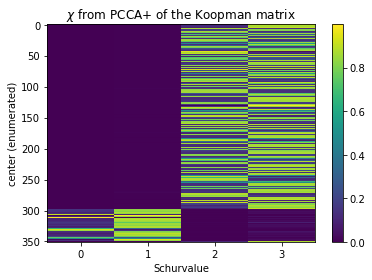

In [7]:
chi, sorted_ew_k = pcca.pcca(Koopman_mtx2[1, :, :], 4, S_)
#visualize pcca+ Koopman matrix 
plt.imshow( chi, aspect="auto")
plt.title("$\chi$ from PCCA+ of the Koopman matrix")
plt.xticks(np.arange(0,np.shape(chi)[1]))
plt.xlabel("Schurvalue")
plt.ylabel("center (enumerated)")
plt.colorbar()
plt.show()

Optimization terminated successfully.
         Current function value: -581.895786
         Iterations: 504
         Function evaluations: 789


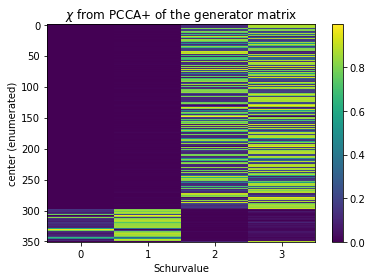

In [8]:
chi_infgen, sorted_ew_q= pcca.pcca(Infgen,4, S_)

plt.imshow(chi_infgen, aspect= "auto")
plt.colorbar()
plt.title("$\chi$ from PCCA+ of the generator matrix")
plt.xticks(np.arange(0,np.shape(chi)[1]))
plt.xlabel("Schurvalue")
plt.ylabel("center (enumerated)")
plt.show()

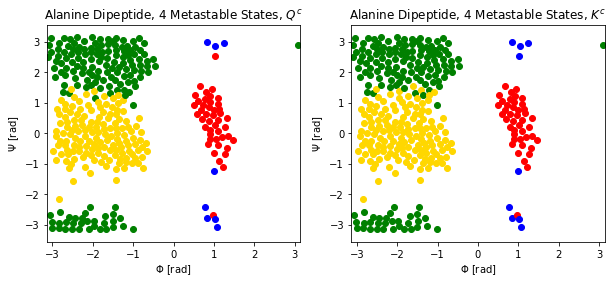

In [9]:

#visualize with center belongs to which metastable state, in addition compare the results for the 
#PCCA+ applied to the transfer matrix and to the generator.
colors = ["b","r","gold","g", "m", "purple"]
centers_1 = centers[centers_kept, :]
plt.figure(figsize=(10, 4))
plt.subplot(121)
for i in range(np.shape(chi_infgen)[0]):
    plt.scatter(centers_1[i, 0], centers_1[i, 1], color = colors[np.argmax(chi_infgen[i, :])])
plt.xlabel("$\Phi$ [rad]")
plt.ylabel("$\Psi$ [rad]")
plt.title("Alanine Dipeptide, 4 Metastable States, $Q^c$")
plt.xlim(-np.pi, np.pi)

plt.subplot(122)
for i in range(np.shape(chi_infgen)[0]):
 
    plt.scatter(centers_1[i, 0], centers_1[i, 1], color = colors[np.argmax(chi[i, :])])
plt.xlabel("$\Phi$ [rad]")
plt.ylabel("$\Psi$ [rad]")
plt.title("Alanine Dipeptide, 4 Metastable States, $K^c$")
plt.xlim(-np.pi, np.pi)
plt.show()

The coarse grained generator can be obtained with $Q^c=\chi^{-1}Q\chi$

In [10]:
Q_c = np.linalg.pinv(chi_infgen).dot(Infgen.dot(chi_infgen))